In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#machine learning inputs
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load in Data and make data cuts
- T-eff < 7000 to exclude high mass stars and most white dwarfs. 
- parallax > 1e-5
- G band Magnitude <18


In [4]:
# colnames = [
#     "starID",  #Assigned star ID
#     "Gaia", #Star ID from Gaia catalog
#     "Teff", #Effective temperature of the star (a derived quantity)
#     "e_Teff", #Error in effective temperature
#     "logg", #Log surface gravity
#     "e_logg", #error in surface gravity
#     "FeH", #Metallicity (ratio of iron to hydrogen)
#     "e_FeH", #error in metallicity
#     "Dist", #Distance to star
#     "e_Dist", #Error in distance to star
#     "Av", #Extintion of light along the line of sight 
#     "e_Av", #error in extinction
#     "Fbol", #Bolometric flux (integrated over all wavelengths)
#     "e_Fbol", #Error in bolometric flux
#     "angRad", #angular radius of star
#     "e_angRad", #Error in angular radius
#     "logL", #log bolometric luminosity
#     "e_logL", #error in log luminosity
#     "radius", #radius of the star
#     "e_radius", #error in radius
#     "npoint", #number of points in flux
#     "source", #target source
#     "ruwe", #Gaia weighted error
#     "RAdeg", #RA coordinate in degrees
#     "DEdeg", #DEC coordinate in degrees
#     "GLON", #galactic latitude
#     "GLAT", #galactic latitude
#     "Uniq", #is it a unique point
#     "BinarySource" #yes or no is it a binary source
# ]

#Data cleaning step already completed
# chunks = pd.read_csv("apjsacabc8t4_mrt.txt", names=colnames, sep=r"\s+", comment='#', engine='python', chunksize=50000)
# filtered_chunks=[]
# for chunk in chunks:
#     chunk = chunk[pd.to_numeric(chunk['Teff'], errors='coerce') < 9000]
#     chunk = chunk[chunk['Uniq'] == 'Y']
#     chunk = chunk.drop(['starID', 'Gaia', 'BinarySource', 'Uniq', 'ruwe', 'source'], axis=1)
#     chunk = chunk.apply(pd.to_numeric, errors='coerce')
#     chunk = chunk.dropna()
#     filtered_chunks.append(chunk)

# df = pd.concat(filtered_chunks)
# df.head()
# df.to_csv('GALAH_APOGEE_RAVE.csv', index=False)

In [5]:
df = pd.read_csv('GALAH_APOGEE_RAVE.csv')
df.head()

,Teff,e_Teff,logg,e_logg,FeH,e_FeH,Dist,e_Dist,Av,e_Av,...,e_angRad,logL,e_logL,radius,e_radius,npoint,RAdeg,DEdeg,GLON,GLAT
0,4226.1,141.9,4.62,0.07,-0.13,0.12,142.844,0.187,0.143,0.198,...,0.00158,-0.976,0.037,0.608,0.049,16.0,53.221178,-68.674790,284.403250,-42.173533
1,4908.7,171.8,2.32,0.08,-1.18,0.19,3483.971,100.874,0.112,0.160,...,0.00107,1.667,0.048,9.451,0.846,19.0,55.593978,-68.697933,283.721464,-41.476288
2,5560.0,153.3,4.07,0.06,0.02,0.10,800.286,10.866,0.149,0.118,...,0.00068,0.401,0.037,1.716,0.120,19.0,54.392074,-68.685000,284.059066,-41.833071
3,5623.7,156.4,4.28,0.06,-0.03,0.11,411.509,4.184,0.057,0.117,...,0.00103,0.190,0.037,1.315,0.092,19.0,55.770496,-68.722452,283.697372,-41.410086
4,6024.5,164.4,4.19,0.06,-0.35,0.15,549.269,10.376,0.078,0.107,...,0.00083,0.377,0.040,1.421,0.102,19.0,55.738304,-68.746178,283.732101,-41.405527


In [4]:
def get_Mbol(logLbol):
    Mbol = 71.19-(2.5*logLbol) #IAU 2015 definition
    return Mbol

Mbol_Yu = get_Mbol(df['logL'])

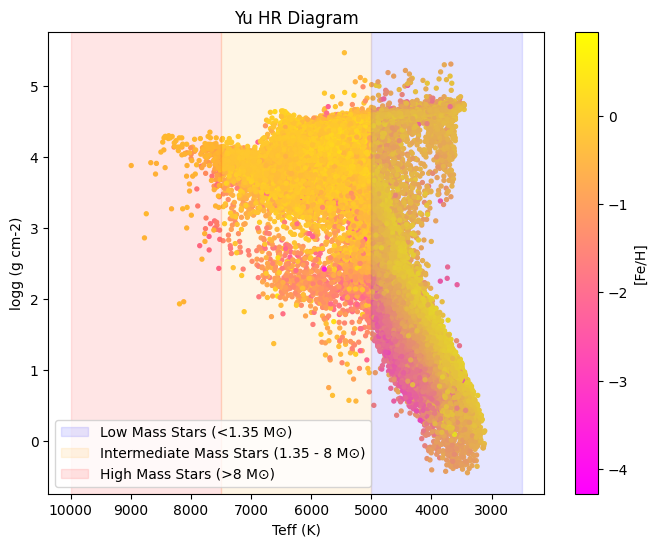

In [6]:
plt.figure(figsize=(8, 6))

sc = plt.scatter(df['Teff'].iloc[::5], df['logg'].iloc[::5], c=df['FeH'].iloc[::5], cmap='spring', s=8)
plt.colorbar(sc, label='[Fe/H]')
plt.gca().invert_xaxis()
plt.xlabel('Teff (K)')
plt.ylabel("logg (g cm-2)")
plt.title("Yu HR Diagram")

#Hr diagram markers 
teff = df['Teff']
# Define mass boundaries (for example, in solar masses)
low_mass = (teff < 6550)  # Low mass stars have lower Teff (this is a rough example)
intermediate_mass = (teff >= 6550) & (teff < 7000)  # Intermediate mass
high_mass = (teff >= 7000)  # High mass stars

# Plot shaded regions for mass groups
plt.axvspan(2500, 5000, color='blue', alpha=0.1, label='Low Mass Stars (<1.35 M⊙)')
plt.axvspan(5000, 7500, color='orange', alpha=0.1, label='Intermediate Mass Stars (1.35 - 8 M⊙)')
plt.axvspan(7500, 10000, color='red', alpha=0.1, label='High Mass Stars (>8 M⊙)')

# Annotating the regions (optional)
# plt.annotate('Low Mass Stars', xy=(4500, 5), xytext=(4500, 4.7),
#              arrowprops=dict(facecolor='blue', shrink=0.05), color='blue', fontsize=10)
# plt.annotate('Intermediate Mass Stars', xy=(6000, 4), xytext=(6000, 4.2),
#              arrowprops=dict(facecolor='orange', shrink=0.05), color='orange', fontsize=10)
# plt.annotate('High Mass Stars', xy=(18000, -2), xytext=(18000, -2.2),
#              arrowprops=dict(facecolor='red', shrink=0.05), color='red', fontsize=10)

# Show the plot
plt.legend()
plt.savefig('Yu_HR.png', dpi=200)
plt.show()

In [5]:
def clustering(nclust, X, true_labels, centers_arg=True):
    kmeans = KMeans(n_clusters=nclust, random_state=0, n_init="auto").fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # Sort cluster labels by Teff (column 0)
    sorted_indices = np.argsort(centers[:, 0])
    label_mapping = {old: new for new, old in enumerate(sorted_indices)}
    labels = np.vectorize(label_mapping.get)(labels)

    # Downsample for plotting
    x_plot = df['Teff'].iloc[::5]
    y_plot = X['logL'].iloc[::5]

    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Scatter plots
    points = axs[0].scatter(x_plot, y_plot, c=labels[::5], s=4)
    misclassified = labels[::5] - true_labels[::5]
    points_misclass = axs[1].scatter(x_plot, y_plot, c=misclassified, s=4, cmap='Set1')

    # Plot spectral lines and labels
    spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
    teff_values = [7220, 6550, 5930, 5270, 3850]

    for ax in axs:
        y_top = ax.get_ylim()[1]
        for teff, label in zip(teff_values, spectral_types_break):
            ax.axvline(teff, color='black', linestyle='--', linewidth=0.8)
            y_offset = 0.3 if label != 'Kraft Break' else 1.2
            ax.text(teff, y_top - y_offset, label,
                    rotation=90 if label == 'Kraft Break' else 0,
                    verticalalignment='top',
                    horizontalalignment='center',
                    fontsize=9)
            
        if centers_arg:
            ax.scatter(centers[:, 0], centers[:, 4], marker='x', c='black', s=80, label='Centers')
        ax.set_title("Clustered HR Diagram")
        ax.set_xlabel('Temperature (K)')
        ax.set_ylabel(r'Bolometric Luminosity ($L_{\odot}$)')
        ax.invert_xaxis()
        ax.legend()

    # Add colorbars
    fig.colorbar(points, ax=axs[0], label='Cluster label')
    fig.colorbar(points_misclass, ax=axs[1], label='Label Difference')

    plt.tight_layout()
    plt.show()

    return labels, centers


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2789874623.py, line 25)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [ ]:
fitcolsT = [
    "Teff", #Effective temperature of the star (a derived quantity)
    "logg", #Log surface gravity
    "FeH", #Metallicity (ratio of iron to hydrogen)
    "Fbol", #Bolometric flux (integrated over all wavelengths)
    "logL", #log bolometric luminosity
    "radius", #radius of the star
]
XT = df[fitcolsT]


bin_edges = [float('inf'),  # for F0 and hotter
             (7220 + 6650)/2,
             (6650 + 5930)/2,
             (5930 + 5270)/2,
             (5270 + 3850)/2,
             float('-inf')]  # for M0 and cooler

bin_edges = bin_edges[::-1]  # smallest to largest

spectral_labels = np.arange(6)

conditions = [
    (df['Teff'] > bin_edges[i]) & (df['Teff'] <= bin_edges[i+1])
    for i in range(len(bin_edges) - 1)
]

spectral_labels = [0, 1, 2, 3, 4]

mass_labels = [0, 1, 2]

labels_3clust = np.select(masses, mass_labels)

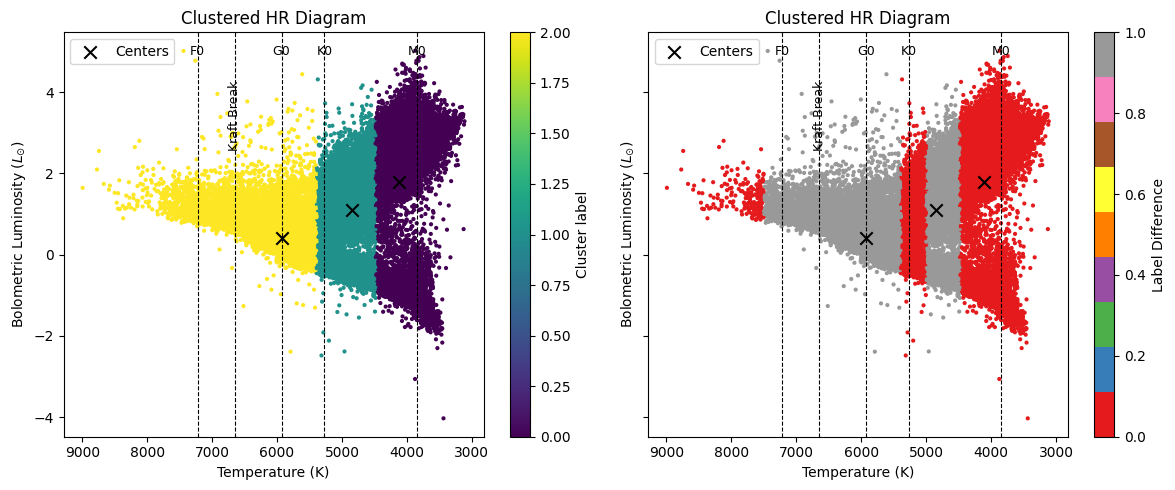

In [9]:
labels3, centers3 = clustering(3, XT, labels_3clust)

In [ ]:
bin_edges = [3850,
             5270,
             5930,
             6650,
             7220,
             float('inf')]

# Define the 6 conditions manually using chained comparisons
spectral_bins = [
    df['Teff'] <= bin_edges[1],
    (df['Teff'] > bin_edges[1]) & (df['Teff'] <= bin_edges[2]),
    (df['Teff'] > bin_edges[2]) & (df['Teff'] <= bin_edges[3]),
    (df['Teff'] > bin_edges[3]) & (df['Teff'] <= bin_edges[4]),
    (df['Teff'] > bin_edges[4]) & (df['Teff'] <= bin_edges[5]),
    df['Teff'] > bin_edges[5]
]

spectral_labels = [0, 1, 2, 3, 4, 5]

labels_6clust = np.select(spectral_bins, spectral_labels)


In [84]:
bin_edges = [float('inf'),  # for F0 and hotter
             (7220 + 6650)/2,
             (6550 + 5930)/2,
             (5930 + 5270)/2,
             (5270 + 3850)/2,
             float('-inf')]  # for M0 and cooler

bin_edges = bin_edges[::-1]  # smallest to largest

spectral_labels = np.arange(6)

conditions = [
    (df['Teff'] > bin_edges[i]) & (df['Teff'] <= bin_edges[i+1])
    for i in range(len(bin_edges) - 1)
]

spectral_labels = [0, 1, 2, 3, 4]

labels_5clust = np.select(conditions, spectral_labels)

/tmp/ipykernel_909/979300056.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


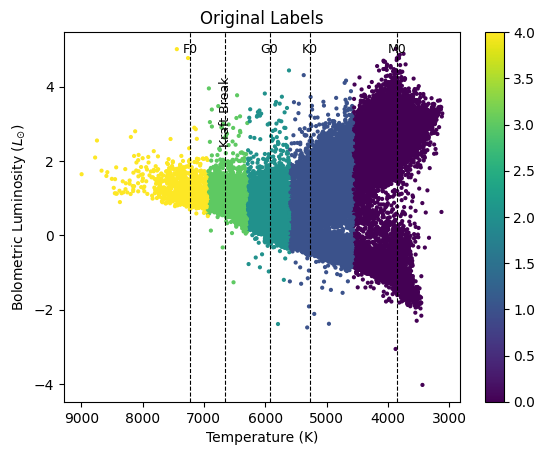

In [91]:
#original data
fig, ax = plt.subplots()
points = ax.scatter(df['Teff'].iloc[::5], df['logL'].iloc[::5], c=labels_5clust[::5], s=4)
ax.set_title("Original Labels")
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Bolometric Luminosity ($L_{\odot}$)')
ax.invert_xaxis()
spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
teff_values = [7220, 6550, 5930, 5270, 3850]
y_top = ax.get_ylim()[1]
for teff, label in zip(teff_values, spectral_types_break):
    ax.axvline(teff, color='black', linestyle='--', linewidth=0.8)
    y_offset = 0.3 if label != 'Kraft Break' else 1.2
    ax.text(teff, y_top - y_offset, label,
            rotation=90 if label == 'Kraft Break' else 0,
            verticalalignment='top',
            horizontalalignment='center',
            fontsize=9)
fig.colorbar(points, ax=ax)
fig.show()


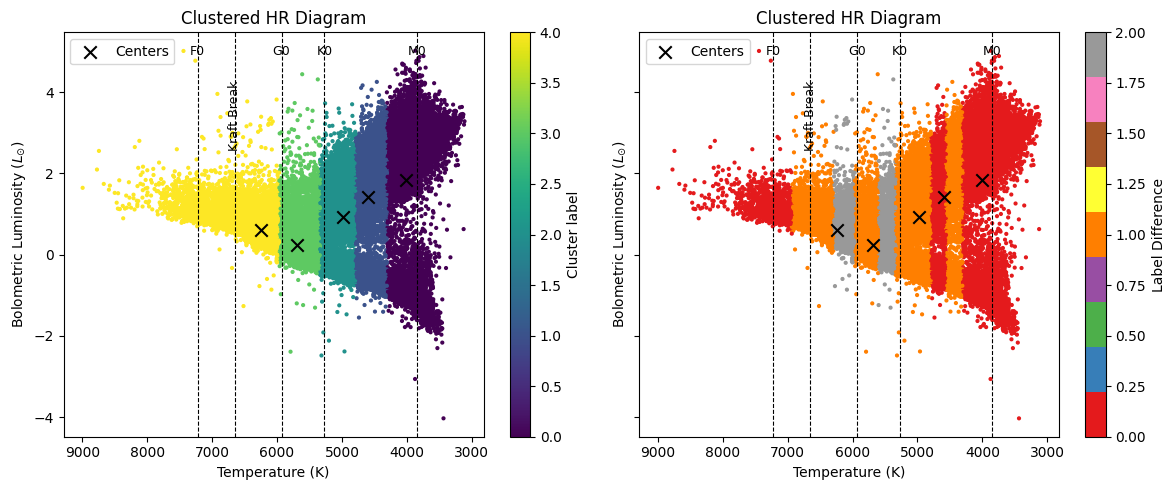

In [ ]:
labels5, clusters5 = clustering(5, XT, labels_5clust)

In [115]:
boundsT = [[min(XT['Teff'].to_numpy()[np.where(labels5==spec_class)]), max(XT['Teff'].to_numpy()[np.where(labels5==spec_class)])] for spec_class in spectral_labels]

It's interesting that despite not telling the algorithm anything about physics, it winds up with these vertical divisions based on temperature anyway. What happens when we take away Teff information?

# Confusion matrix

ConfusionMatrix [[202249 125709      0      0      0]
 [     0 237680 353225  98268      0]
 [     0      0      0 216837 149556]
 [     0      0      0      0  55413]
 [     0      0      0      0   7192]]
              precision    recall  f1-score   support

           0       1.00      0.62      0.76    327958
           1       0.65      0.34      0.45    689173
           2       0.00      0.00      0.00    366393
           3       0.00      0.00      0.00     55413
           4       0.03      1.00      0.07      7192

    accuracy                           0.31   1446129
   macro avg       0.34      0.39      0.26   1446129
weighted avg       0.54      0.31      0.39   1446129



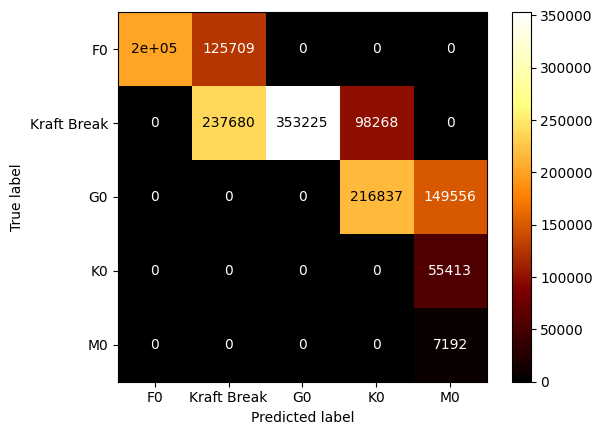

In [ ]:
spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
#teff_values = [7220, 6550, 5930, 5270, 3850]
cm = confusion_matrix(labels_5clust,labels5)
print("ConfusionMatrix",cm)
print(classification_report(labels_5clust,labels5))

disp = ConfusionMatrixDisplay(cm, display_labels = spectral_types_break)
disp.plot(cmap='afmhot')
plt.show()

ConfusionMatrix [[280613 501575      0]
 [     0 152184 510740]
 [     0      0   1017]]
              precision    recall  f1-score   support

           0       1.00      0.36      0.53    782188
           1       0.23      0.23      0.23    662924
           2       0.00      1.00      0.00      1017

    accuracy                           0.30   1446129
   macro avg       0.41      0.53      0.25   1446129
weighted avg       0.65      0.30      0.39   1446129



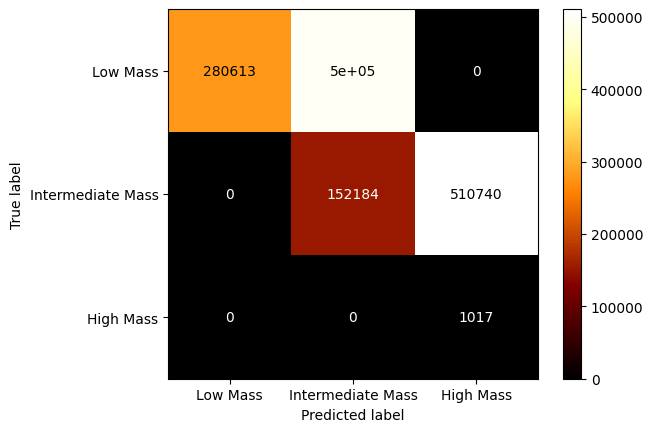

In [13]:
spectral_types_break = ['Low Mass', 'Intermediate Mass', 'High Mass']
#teff_values = [7220, 6550, 5930, 5270, 3850]
cm = confusion_matrix(labels_3clust,labels3)
print("ConfusionMatrix",cm)
print(classification_report(labels_3clust, labels3))
disp = ConfusionMatrixDisplay(cm, display_labels = spectral_types_break)
disp.plot(cmap='afmhot')
plt.show()

In [51]:
fitcolsnT = [
    "logg", #Log surface gravity
    "FeH", #Metallicity (ratio of iron to hydrogen)
    "angRad", #angular radius of star
    "logL", #log bolometric luminosity
    "radius", #radius of the star
]
XnT = df[fitcolsnT]

/tmp/ipykernel_909/242479057.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


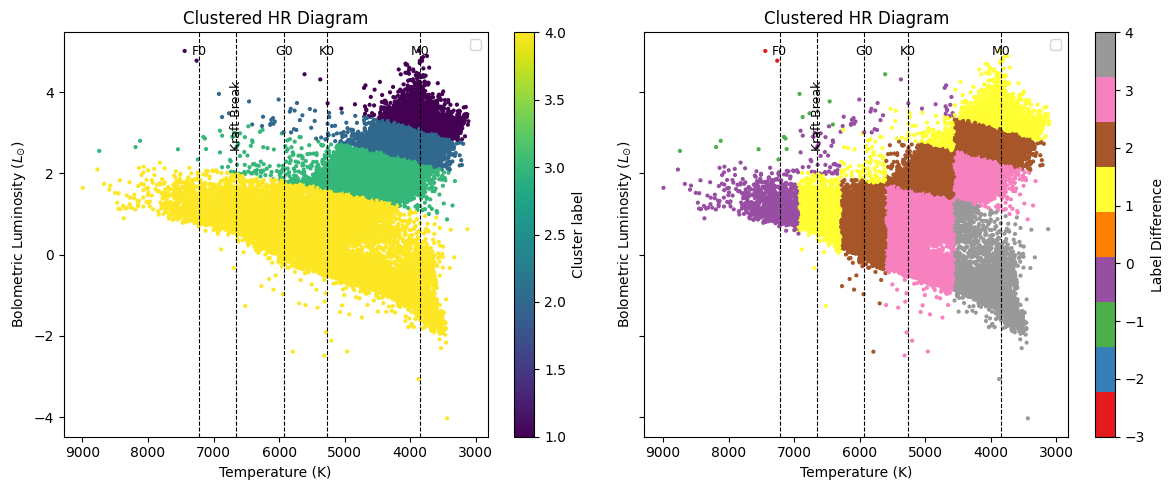

In [109]:
labels5nT, clusters5nT = clustering(5, XnT, labels_5clust, centers_arg=False)

In [118]:
boundsnT = [[min(df['Teff'].to_numpy()[np.where(labels5nT==spec_class)]), max(df['Teff'].to_numpy()[np.where(labels5nT==spec_class)])] for spec_class in spectral_labels]
print(boundsnT)
print(boundsT)

[[np.float64(3801.4), np.float64(3801.4)], [np.float64(3107.1), np.float64(7440.7)], [np.float64(3163.1), np.float64(7504.4)], [np.float64(3165.1), np.float64(8742.7)], [np.float64(3126.7), np.float64(8993.5)]]
[[np.float64(3107.1), np.float64(4308.4)], [np.float64(4302.5), np.float64(4790.9)], [np.float64(4790.7), np.float64(5336.4)], [np.float64(5336.5), np.float64(5966.9)], [np.float64(5967.0), np.float64(8993.5)]]


ConfusionMatrix [[     1  18498  90155 158615  60689]
 [     0     84   1689 298877 388523]
 [     0     13     76    527 365777]
 [     0      4     34    172  55203]
 [     0      5      8     55   7124]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00    327958
           1       0.00      0.00      0.00    689173
           2       0.00      0.00      0.00    366393
           3       0.00      0.00      0.00     55413
           4       0.01      0.99      0.02      7192

    accuracy                           0.01   1446129
   macro avg       0.20      0.20      0.00   1446129
weighted avg       0.23      0.01      0.00   1446129



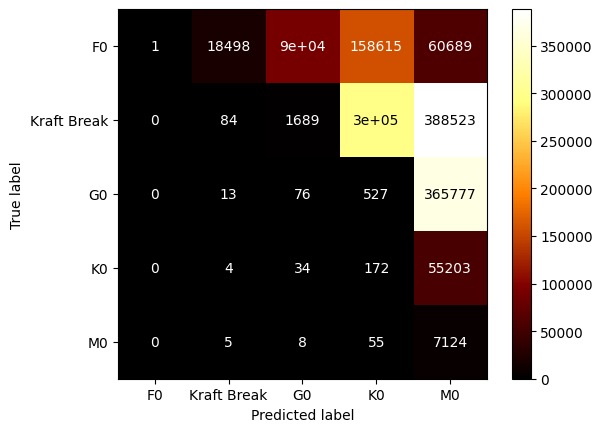

In [111]:
cm = confusion_matrix(labels_5clust,labels5nT)
print("ConfusionMatrix",cm)
print(classification_report(labels_5clust,labels5nT))
disp = ConfusionMatrixDisplay(cm, display_labels = spectral_types_break)
disp.plot(cmap='afmhot')
plt.show()

# PCA

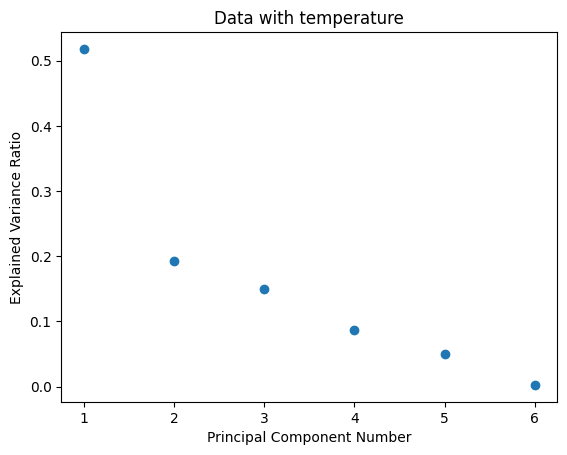

In [61]:
from sklearn.decomposition import PCA
df_norm = (XT - XT.mean()) / XT.std()
ncomp=len(fitcolsT)
pcaT = PCA(n_components=ncomp)
x_transform = pcaT.fit_transform(df_norm)
explained_variances = pcaT.explained_variance_ratio_
plt.scatter(np.arange(1,ncomp+1), explained_variances)
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Data with temperature')
plt.show()

In [ ]:
loadingsT = pd.DataFrame(pcaT.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(fitcolsT))],
                        index=XT.columns)
loadingsT


,PC1,PC2,PC3,PC4,PC5,PC6
Teff,0.413418,0.104571,-0.393782,0.770417,0.135021,-0.226526
logg,0.541630,0.169069,-0.088321,-0.185041,0.268665,0.750887
FeH,0.226320,0.274352,0.890224,0.279443,0.006289,-0.053699
Fbol,-0.119283,0.860901,-0.206665,-0.078997,-0.442297,0.006679
logL,-0.509171,-0.135016,0.041973,0.535036,-0.231334,0.617232
radius,-0.459368,0.354729,-0.012796,0.040321,0.812654,-0.030853


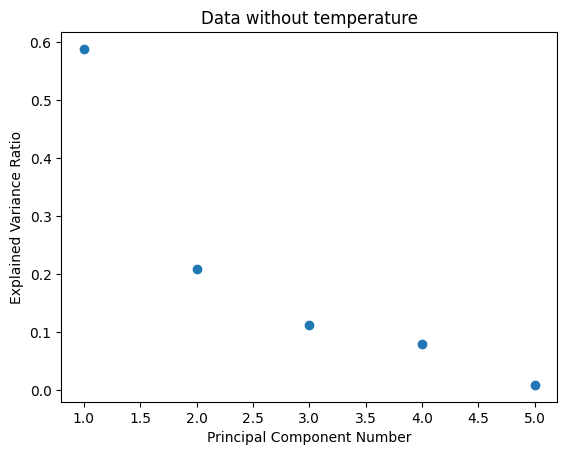

In [63]:
from sklearn.decomposition import PCA
df_norm = (XnT - XnT.mean()) / XnT.std()
ncomp=len(fitcolsnT)
pcanT = PCA(n_components=ncomp)
x_transform = pcanT.fit_transform(df_norm)
explained_variances = pcanT.explained_variance_ratio_
plt.scatter(np.arange(1,ncomp+1), explained_variances)
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Data without temperature')
plt.show()

In [ ]:
loadingsnT = pd.DataFrame(pcanT.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(fitcolsnT))],
                        index=XnT.columns)
loadingsnT

,PC1,PC2,PC3,PC4,PC5
logg,0.544174,0.097546,0.381088,0.174825,0.720117
FeH,0.221309,0.819621,-0.510802,0.129515,-0.039388
angRad,-0.371626,0.544256,0.595563,-0.459317,0.003441
logL,-0.537971,-0.061404,-0.434680,-0.195926,0.692448
radius,-0.476842,0.136829,0.224080,0.838632,0.019622


# Supervised classification

In [123]:
spectral_types_clf_labels = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
teff_values = [7220, 6550, 5930, 5270, 3850]

reg_df = df.copy()
reg_df['label'] = labels_5clust

In [122]:
#Random forest classification because it is supervised, so train some of the data on classification system and then test on 20%

#Split data into train and test set
X = reg_df[fitcolsT]
y = reg_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
clf = RandomForestClassifier(n_estimators = 100, random_state = 42, criterion='log_loss')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

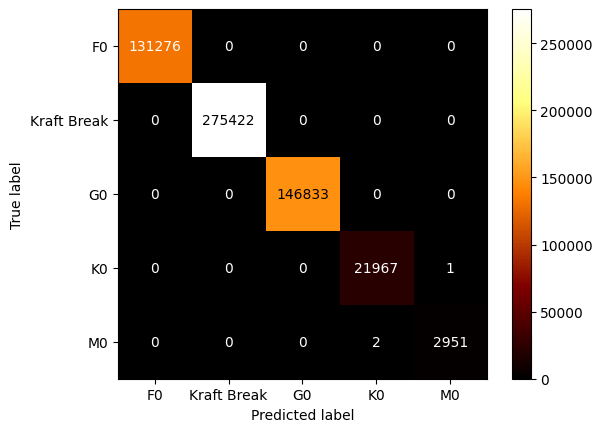

In [124]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = spectral_types_clf_labels)
disp.plot(cmap='afmhot')
plt.show()

/tmp/ipykernel_909/751481273.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


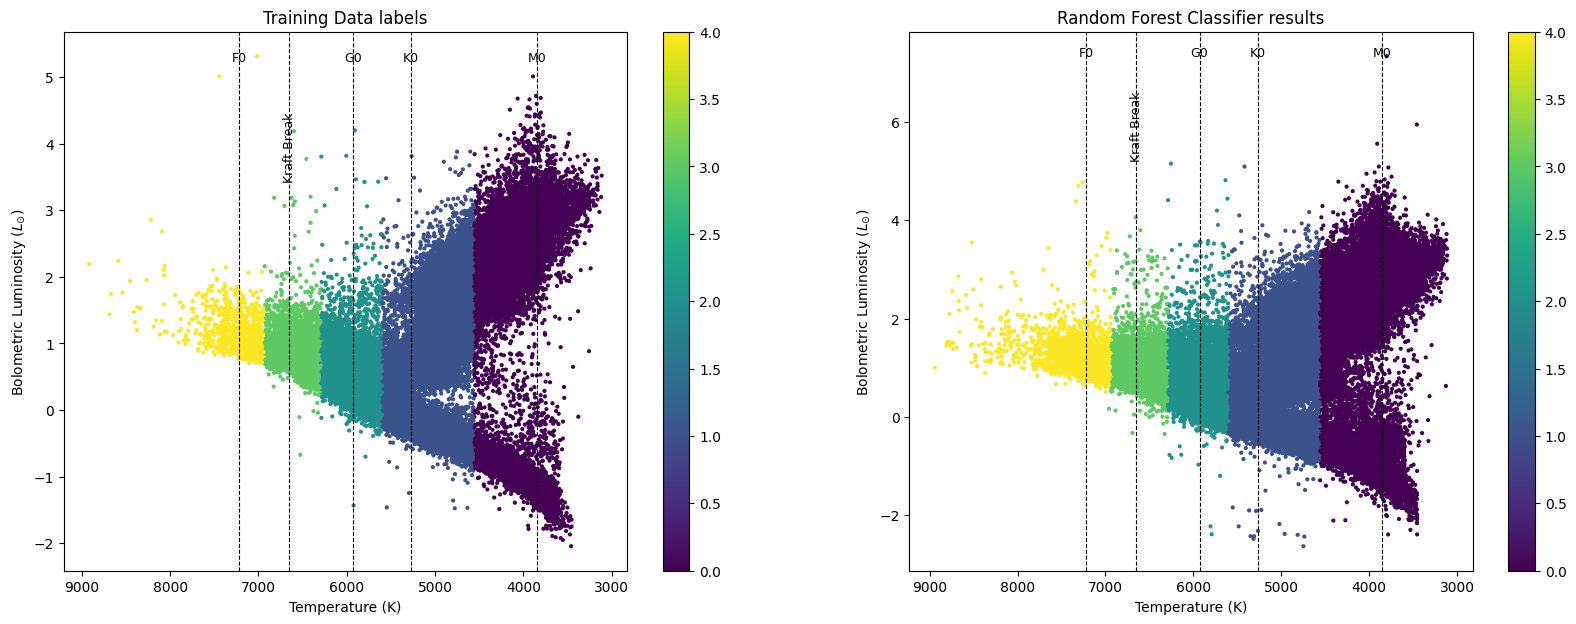

In [100]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
points = ax[1].scatter(X_test['Teff'], X_test['logL'], c=y_pred, s=4)
ax[0].scatter(X_train['Teff'].iloc[::5], X_train['logL'].iloc[::5], c=y_train[::5], s=4)
ax[1].set_title("Random Forest Classifier results")
ax[0].set_title("Training Data labels")

for a in ax:
    a.set_xlabel('Temperature (K)')
    a.set_ylabel(r'Bolometric Luminosity ($L_{\odot}$)')
    a.invert_xaxis()
    y_top = a.get_ylim()[1]
    for teff, label in zip(teff_values, spectral_types_break):
        a.axvline(teff, color='black', linestyle='--', linewidth=0.8)
        y_offset = 0.3 if label != 'Kraft Break' else 1.2
        a.text(teff, y_top - y_offset, label,
                rotation=90 if label == 'Kraft Break' else 0,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=9)
    fig.colorbar(points, ax=a)

fig.show()

In [126]:
boundsRFC = [[min(df['Teff'].to_numpy()[np.where(y_pred==spec_class)]), max(df['Teff'].to_numpy()[np.where(y_pred==spec_class)])] for spec_class in spectral_labels]
boundsRFC

[[np.float64(3254.2), np.float64(7961.4)],
 [np.float64(3432.3), np.float64(8544.7)],
 [np.float64(3425.8), np.float64(8483.6)],
 [np.float64(3529.1), np.float64(7902.9)],
 [np.float64(3629.8), np.float64(7632.4)]]